In [1]:
import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

c:\Users\vansh\miniconda3\lib\site-packages\scipy\__init__.py:177: UserWarning: A NumPy version >=1.18.5 and <1.26.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

In [11]:
train_images = train_images.reshape(
    train_images.shape[0], 28, 28, 1).astype('float32')
# Normalize the images to [-1, 1]
train_images = (train_images - 127.5) / 127.5
BUFFER_SIZE = 60000
BATCH_SIZE = 256
train_dataset = tf.data.Dataset.from_tensor_slices(
    train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [19]:
def make_generator_model(dim):
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(dim,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    # Note: None is the batch size
    model.add(layers.Conv2DTranspose(
        256, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(
        64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2),
              padding='same', use_bias=False, activation='tanh'))

    return model


def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

(1, 28, 28, 1)
tf.Tensor([[-0.00013288]], shape=(1, 1), dtype=float32)


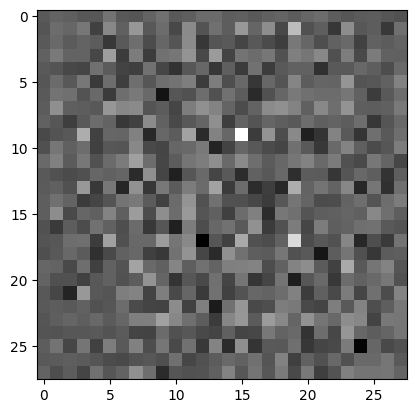

In [24]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# noise = tf.random.normal([1, 64])
# generator = make_generator_model(64)
# discriminator = make_discriminator_model()
# generated_image = generator(noise, training=False)
# print(generated_image.shape)
# decision = discriminator(generated_image)


# print(decision)
# plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [7]:
class Trainer():
	def __init__(self, gen,dis, g_opt,d_opt,dim):
		self.gen = gen
		self.dis =dis
		self.g_opt = g_opt
		self.d_opt = d_opt
		self.dim =dim
   

	@tf.function
	def train_step(self,images):
		noise = tf.random.normal([BATCH_SIZE, self.dim])

		with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
			generated_images = self.gen(noise, training=True)

			real_output = self.dis(images, training=True)
			fake_output = self.dis(generated_images, training=True)

			gen_loss = generator_loss(fake_output)
			disc_loss = discriminator_loss(real_output, fake_output)

		gradients_of_generator = gen_tape.gradient(
			gen_loss, self.gen.trainable_variables)
		gradients_of_discriminator = disc_tape.gradient(
			disc_loss, self.dis.trainable_variables)

		self.g_opt.apply_gradients(
			zip(gradients_of_generator, self.gen.trainable_variables))
		self.d_opt.apply_gradients(
			zip(gradients_of_discriminator, self.dis.trainable_variables))

In [8]:
def generate_and_save_images(model, epoch, test_input,dim):
	predictions = model(test_input, training=False)
	fig = plt.figure(figsize=(10, 10))
	for i in range(predictions.shape[0]):
		plt.subplot(1, 5, i+1)
		plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
		plt.axis('off')
	plt.savefig('image_at_epoch_{:04d}_{:02d}.png'.format(epoch,dim))
	plt.show()

def train(dataset, epochs,dim,gen,dis,d_opt,g_opt):
	t = Trainer(gen,dis,g_opt,d_opt,dim)
	seed = tf.random.normal([5, dim])

	for epoch in range(epochs):
		start = time.time()
		for image_batch in dataset:
			t.train_step(image_batch)
		# Produce images for the GIF as you go
		display.clear_output(wait=True)
		generate_and_save_images(gen,
								epoch + 1,
								seed,dim)

		print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

	display.clear_output(wait=True)
	generate_and_save_images(gen,
							epochs,
							seed,dim)

In [9]:
EPOCHS = 50
num_examples = 5

for dim in [2,4,8,16,32,64]:
	generator = make_generator_model(dim)
	discriminator = make_discriminator_model()
	generator_optimizer = tf.keras.optimizers.Adam(1e-4)
	discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)
	seed = tf.random.normal([num_examples, dim])
	train(train_dataset, EPOCHS,dim,generator,discriminator,discriminator_optimizer,generator_optimizer)
    

c:\Users\vansh\miniconda3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\vansh\miniconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

In [ ]:
def make_gif(latent_dim):
	anim_file = 'GAN{:d}.gif'.format(latent_dim)
	with imageio.get_writer(anim_file, mode='I') as writer:
		filenames = ['./image_at_epoch_{:04d}_{:02d}.png'.format(
			i, latent_dim) for i in range(1, EPOCHS+1)]
		# filenames = sorted(filenames)

		for filename in filenames:
			image = imageio.imread(filename)
			writer.append_data(image)
		image = imageio.imread(filename)
		writer.append_data(image)